In [9]:
import sys
import os
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sys.path.append('..\..')
from utils.post_processing_utils import get_all_experimental_records, remove_exps_after_manipulations, remove_unsuitable_recordings, remove_manipulation_days
from utils.plotting_visuals import makes_plots_pretty
from utils.plotting import multi_conditions_plot
from set_global_params import raw_tracking_path, state_change_mice, processed_data_path, reproduce_figures_path, spreadsheet_path
from utils.stats import cohen_d_paired
import shutil

# Just needed if you don't have repro data, otherwise skip to next heading

In [14]:
site = 'tail'
repro_file = os.path.join(reproduce_figures_path, 'ED_fig6', 'state_change_summary_no_traces.csv')
# traces are not needed for this, it's just to get the trial numbers in the photometry plots
if not os.path.exists(repro_file):
    processed_data_dir = os.path.join(processed_data_path, 'state_change_data')
    state_change_data_file_old = os.path.join(processed_data_dir, 'state_change_data_{}_mice_only_correct_py36.p'.format(site))
    all_session_change_data_old = pd.read_pickle(state_change_data_file_old)
    without_traces = all_session_change_data.drop(columns='traces') # saves space - traces are huge
    without_traces.to_csv(repro_file)
all_session_change_data = pd.read_csv(repro_file, index_col=0)

In [24]:
recording_site = 'tail'
mice = state_change_mice[recording_site]
turn_angles = []
stimulus = []
speeds = []
mice_for_df = []
for mouse in mice:
    all_experiments = get_all_experimental_records()
    all_experiments = remove_unsuitable_recordings(all_experiments)
    experiments_to_process = all_experiments[
        (all_experiments['mouse_id'] == mouse) & (all_experiments['recording_site'] == recording_site) & (all_experiments['experiment_notes'] == 'state change white noise')]
    dates = experiments_to_process['date'].values[-4:]
    date = dates[0]
    
    repro_movement_file = os.path.join(reproduce_figures_path, 'ED_fig6', 'state_change_movement','APE_tracking{}_{}.csv'.format(mouse, date))
    if not os.path.exists(repro_movement_file):
        if not os.path.exists(os.path.join(reproduce_figures_path, 'ED_fig6', 'state_change_movement')):
            os.makedirs(os.path.join(reproduce_figures_path, 'ED_fig6', 'state_change_movement'))
        save_out_folder = os.path.join(raw_tracking_path, mouse, date)
        movement_param_file = os.path.join(save_out_folder, 'APE_tracking{}_{}.pkl'.format(mouse, date)) 
        movement_df = pd.read_pickle(movement_param_file).dropna()
        movement_params_for_plots_df = movement_df[['trial numbers', 'fitted max cumsum ang vel', 'average speed', 'side', 'reaction times']]
        movement_params_for_plots_df.to_csv(repro_movement_file)


In [ ]:
def filter_trials_around_reaction_time(side_data, window_around_mean=0.2):
    data = side_data.reset_index(drop=True)
    reaction_times = data['reaction times'].values
    median_reaction_time = np.nanmedian(reaction_times)
    valid_trials = np.where(
            np.logical_and(np.greater_equal(reaction_times, median_reaction_time - window_around_mean),
                           np.less_equal(reaction_times, median_reaction_time + window_around_mean)))
    valid_data = data.loc[valid_trials]
    return valid_data

# is movement different between trial types?

In [25]:
#load photometry data in to get which trials are in photometry analyses
repro_file = os.path.join(reproduce_figures_path, 'ED_fig6', 'state_change_summary_no_traces.csv')
all_session_change_data = pd.read_csv(repro_file, index_col=0)

# load movement data in (from tracking pipeline output)
recording_site = 'tail'
mice = state_change_mice[recording_site]
turn_angles = []
stimulus = []
speeds = []
mice_for_df = []
for mouse in mice:
    all_experiments = get_all_experimental_records()
    all_experiments = remove_unsuitable_recordings(all_experiments)
    experiments_to_process = all_experiments[
        (all_experiments['mouse_id'] == mouse) & (all_experiments['recording_site'] == recording_site) & (all_experiments['experiment_notes'] == 'state change white noise')]
    dates = experiments_to_process['date'].values[-4:]
    date = dates[0]
    repro_movement_file = os.path.join(reproduce_figures_path, 'ED_fig6', 'state_change_movement','APE_tracking{}_{}.csv'.format(mouse, date))
    movement_df = pd.read_csv(repro_movement_file)
    movement_df['abs fitted max cumsum ang vel'] = movement_df['fitted max cumsum ang vel'].abs()

    contra_data = movement_df[movement_df.side == 'contra']
    valid_contra_data = filter_trials_around_reaction_time(contra_data)

    mouse_behavioural_data = all_session_change_data[all_session_change_data['mouse'] == mouse]
    
    pre_trial_nums = mouse_behavioural_data[mouse_behavioural_data['trial type'] == 'pre']['trial number'].values
    post_trial_nums = mouse_behavioural_data[mouse_behavioural_data['trial type'] == 'post']['trial number'].values
    pre_trials = valid_contra_data[valid_contra_data['trial numbers'].isin(pre_trial_nums)]
    post_trials = valid_contra_data[valid_contra_data['trial numbers'].isin(post_trial_nums)]
    pre_trials['stimulus'] = 'tones'
    post_trials['stimulus'] = 'WN'
    all_trials = pd.concat([pre_trials, post_trials]).sort_values(by='trial numbers')
    turn_angles.append(np.mean(pre_trials['abs fitted max cumsum ang vel'].values))
    speeds.append(np.mean(pre_trials['average speed'].values))
    stimulus.append('tones')
    mice_for_df.append(mouse)
    turn_angles.append(np.mean(post_trials['abs fitted max cumsum ang vel'].values))
    speeds.append(np.mean(post_trials['average speed'].values))
    stimulus.append('WN')
    mice_for_df.append(mouse)

C:\Users\francescag\AppData\Local\Temp\ipykernel_21284\2569819834.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_trials['stimulus'] = 'tones'
C:\Users\francescag\AppData\Local\Temp\ipykernel_21284\2569819834.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_trials['stimulus'] = 'WN'
C:\Users\francescag\AppData\Local\Temp\ipykernel_21284\2569819834.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [26]:
pre_post_with_movement = pd.DataFrame({'mouse': mice_for_df, 'stimulus': stimulus, 'turn angle': turn_angles, 'speed': speeds})

In [27]:
turn_angle_for_plot = pre_post_with_movement.pivot(index='stimulus', columns='mouse', values='turn angle').sort_values('stimulus', ascending=False)
speed_for_plot = pre_post_with_movement.pivot(index='stimulus', columns='mouse', values='speed').sort_values('stimulus', ascending=False)

In [31]:
turn_angle_csv = os.path.join(spreadsheet_path, 'ED_fig6', 'ED_fig6P_turn_angle_state_change.csv')
if not os.path.exists(turn_angle_csv):
    (turn_angle_for_plot.T).to_csv(turn_angle_csv)

In [32]:
speed_csv = os.path.join(spreadsheet_path, 'ED_fig6', 'ED_fig6Q_speed_state_change.csv')
if not os.path.exists(speed_csv):
    (speed_for_plot.T).to_csv(speed_csv)

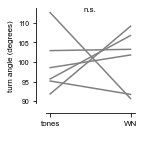

In [28]:
font = {'size': 7}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['font.family']


fig, ax = plt.subplots(figsize=[2,2])
multi_conditions_plot(ax, turn_angle_for_plot, mean_line_color='#7FB5B5', mean_linewidth=0, show_err_bar=False)
plt.xticks([0, 1], ['tones', 'WN'], fontsize=8)
y = turn_angle_for_plot.T.to_numpy().max() + .2
h = .1
plt.ylabel('turn angle (degrees)', fontsize=8)
ax.text(.5, y+h, 'n.s.', ha='center', fontsize=8)
ax.set_xlabel(' ')

plt.tight_layout()


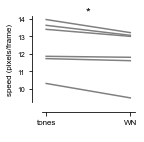

In [8]:
font = {'size': 7}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['font.family']


fig, ax = plt.subplots(figsize=[2,2])
multi_conditions_plot(ax, speed_for_plot, mean_line_color='#7FB5B5', mean_linewidth=0, show_err_bar=False)
plt.xticks([0, 1], ['tones', 'WN'], fontsize=8)
plt.ylabel('speed (pixels/frame)', fontsize=8)

ax.set_xlabel(' ')
y = speed_for_plot.T.to_numpy().max() + .2
h = .1

ax.text(.5, y+h, '*', ha='center', fontsize=12)

plt.tight_layout()


In [9]:
pre_data = pre_post_with_movement[pre_post_with_movement['stimulus'] == 'tones']
post_data = pre_post_with_movement[pre_post_with_movement['stimulus'] == 'WN']

In [10]:
stats.ttest_rel(pre_data.speed, post_data.speed)

Ttest_relResult(statistic=3.47269796688869, pvalue=0.01779770295474364)

In [12]:
cohen_d_paired(pre_data.speed, post_data.speed)

cohen d:  1.4177230082796404


1.4177230082796404

In [13]:
stats.ttest_rel(pre_data['turn angle'], post_data['turn angle'])

Ttest_relResult(statistic=-0.19869820054790038, pvalue=0.8503256610833104)

In [14]:
cohen_d_paired(pre_data['turn angle'], post_data['turn angle'])

cohen d:  -0.08111820069192614


-0.08111820069192614